In [44]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=BIGGER_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 2.)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
sorted_trials, _, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [4]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

In [5]:
sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

sorted neural data shape: (265, 514, 30)


In [6]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [7]:
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

In [8]:
thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 384, 30)


In [9]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/best_bic_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 450, 30)


In [10]:
def plot_localization_features(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-25, x.max()+25)
            axes[0].set_ylim(z.min()-25, z.max()+25)
            axes[1].set_xlim(0, maxptp.max()+25)
            axes[1].set_ylim(z.min()-25, z.max()+25)
        else:    
            axes[0].set_xlim(-100, 175)
            axes[0].set_ylim(-80, 4000)
            axes[1].set_xlim(0, 60)
            axes[1].set_ylim(-80, 4000)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('max ptp (amp)')
    axes[1].set_ylabel('z (um)')
    axes[1].set_title('')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1.5)
        axes[1].spines[ax].set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

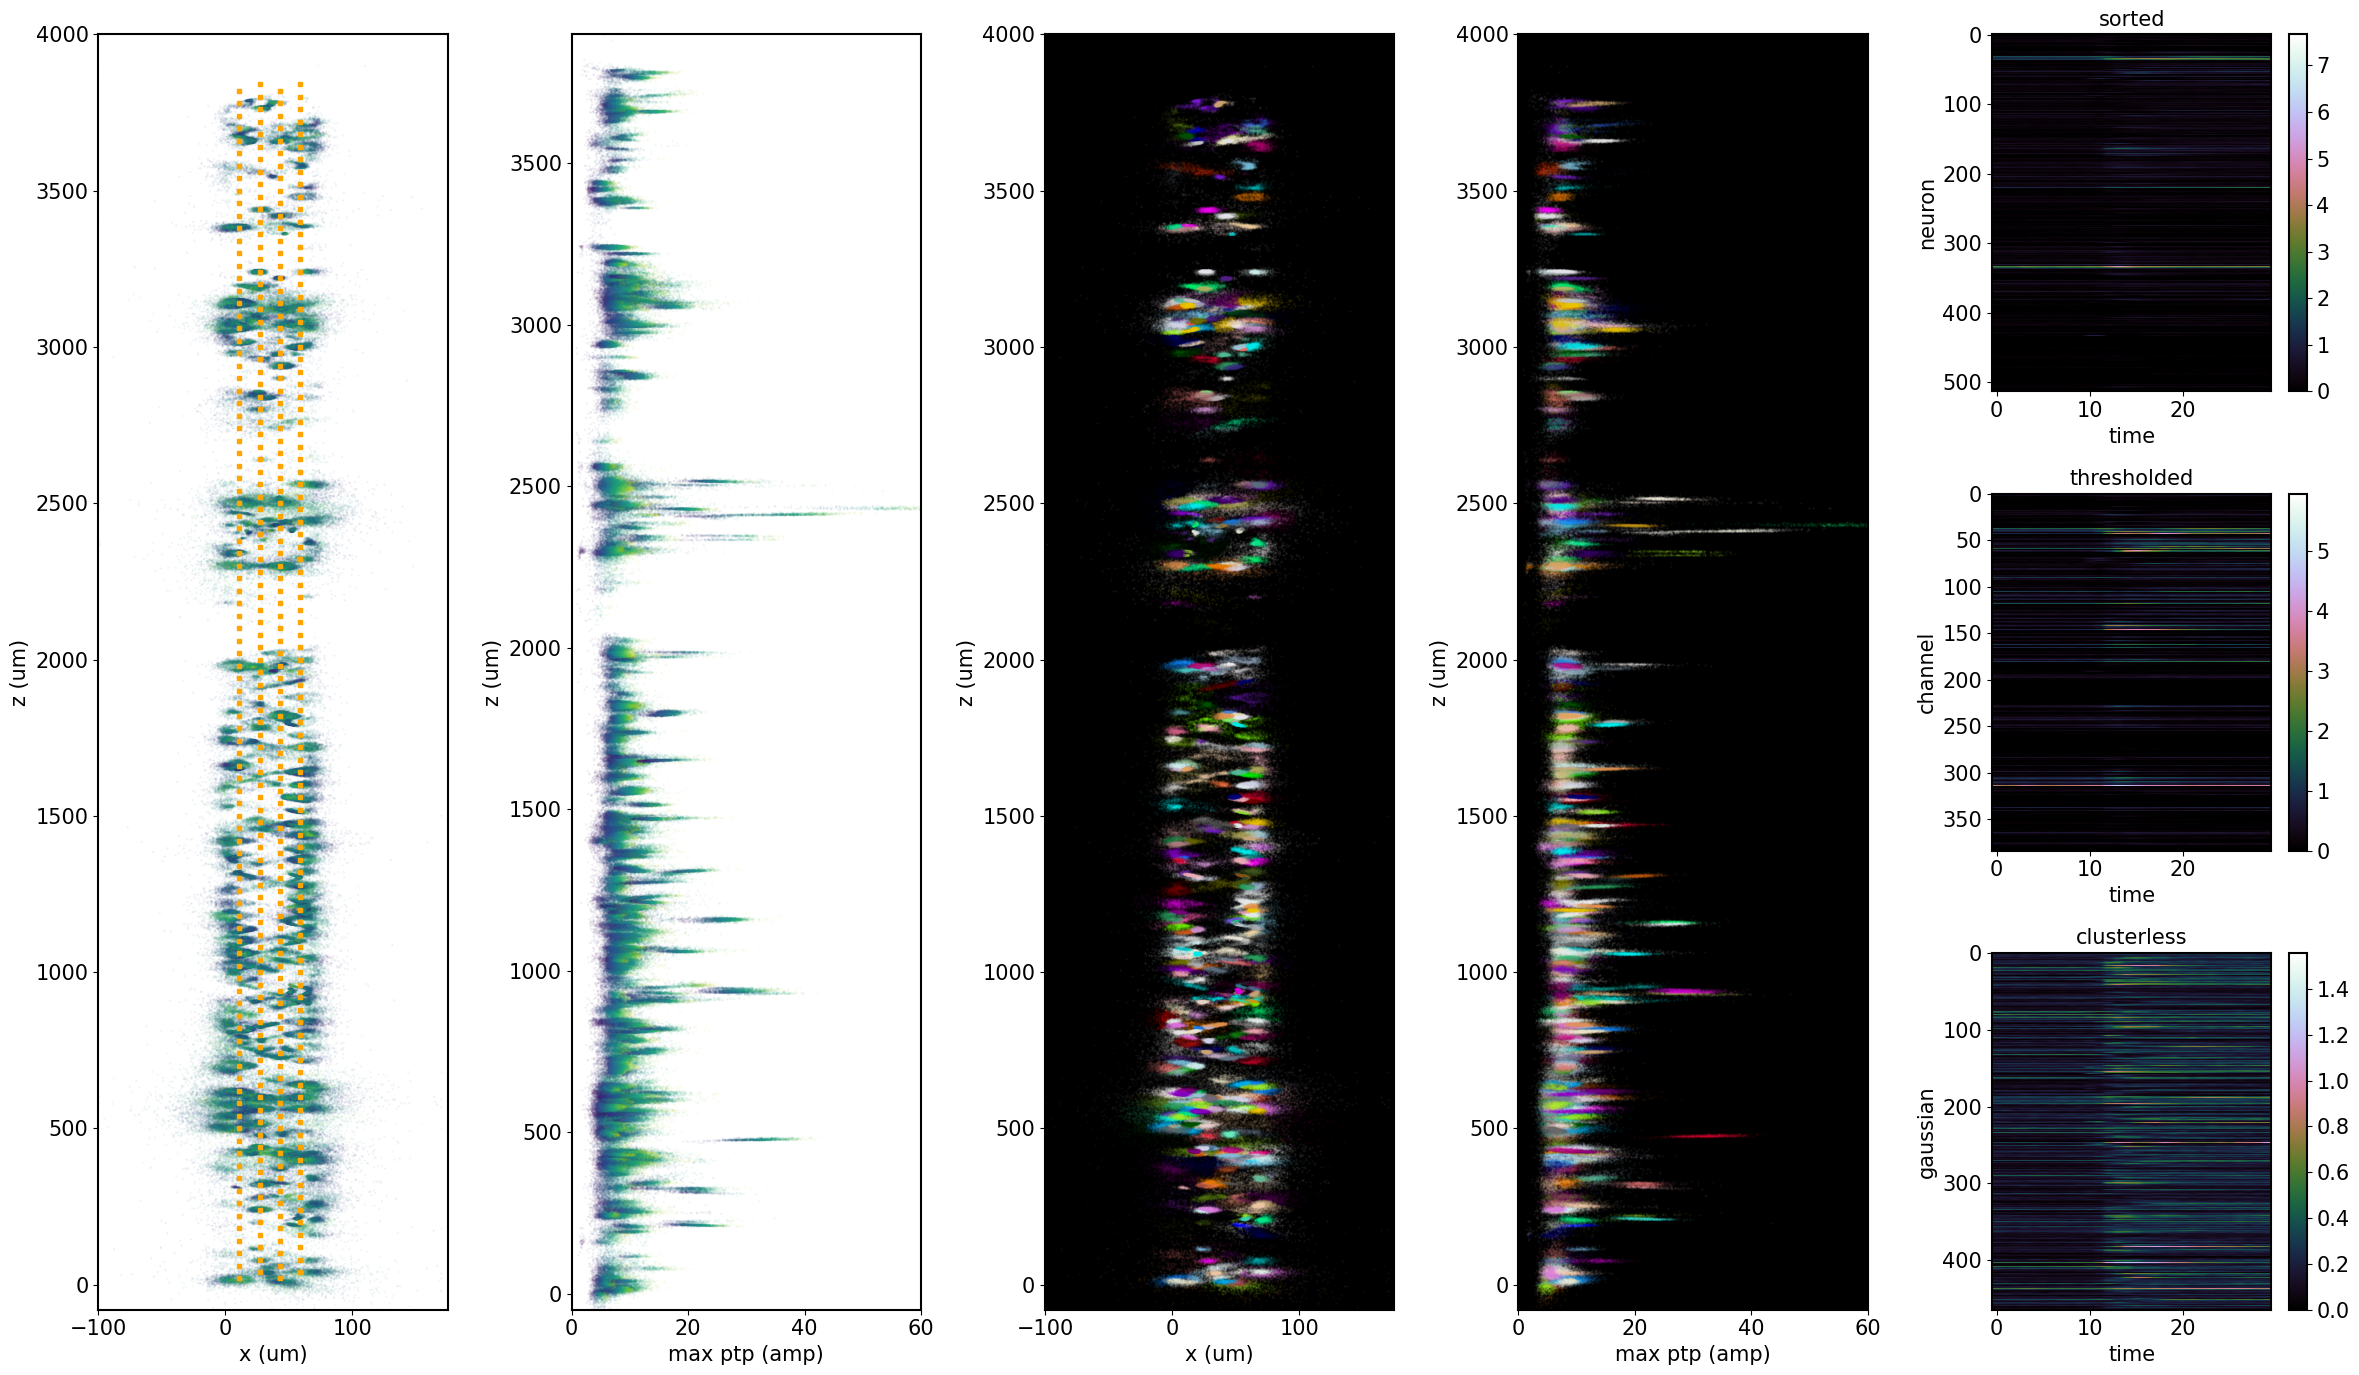

In [119]:
fig = plt.figure(figsize=(24,14))

gs = GridSpec(3, 5) 
colors = [k for k,v in pltc.cnames.items()]
random.shuffle(colors)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1]) 
ax3 = fig.add_subplot(gs[:,2]) 
ax4 = fig.add_subplot(gs[:,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[1,4])
ax7 = fig.add_subplot(gs[2,4])

n_spikes = 1_000
channels = np.arange(384)
for idx in np.unique(spike_labels):
    c = int(idx)
    if idx >= len(colors):
        c = c // 6
        
    sub_data = spike_features[spike_labels == idx]
    x, z, maxptp = sub_data.T
    
    ax1.scatter(x[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=maxptp[:n_spikes])
    ax2.scatter(maxptp[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=maxptp[:n_spikes])
    ax3.scatter(x[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=colors[c])
    ax4.scatter(maxptp[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=colors[c])
    
if len(channels) > 0: 
    for channel in channels:
        ax1.plot(np1_channel_map[int(channel), 0], np1_channel_map[int(channel), 1], 
                     markersize=2.25, c='orange', marker="s")
        # ax3.plot(np1_channel_map[int(channel), 0], np1_channel_map[int(channel), 1], 
        #              markersize=2.25, c='orange', marker="s")

p5 = ax5.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax5.set_title('sorted')
ax5.set_xlabel('time') # change to seconds
ax5.set_ylabel('neuron')
plt.colorbar(p5, ax=ax5);  # make color bars all same colorscale

        
p6 = ax6.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax6.set_title('thresholded')
ax6.set_xlabel('time') # change to seconds
ax6.set_ylabel('channel')
plt.colorbar(p6, ax=ax6);  # make color bars all same colorscale

p7 = ax7.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax7.set_title('clusterless')
ax7.set_xlabel('time') # change to seconds
ax7.set_ylabel('gaussian')
plt.colorbar(p7, ax=ax7);  # make color bars all same colorscale
    
ax1.set_xlim(-100, 175)
ax1.set_ylim(-80, 4000)
ax1.set_facecolor('white')
# plt.colorbar(ax=ax1, location='left')
ax2.set_xlim(0, 60)
ax2.set_ylim(-50, 3900)
ax2.set_facecolor('white')
ax3.set_xlim(-100, 175)
ax3.set_ylim(-80, 4000)
ax3.set_facecolor('black')
ax4.set_xlim(0, 60)
ax4.set_ylim(-80, 4000)
ax4.set_facecolor('black')
ax1.set_xlabel('x (um)')
ax1.set_ylabel('z (um)')
ax2.set_xlabel('max ptp (amp)')
ax2.set_ylabel('z (um)')
ax3.set_xlabel('x (um)')
ax3.set_ylabel('z (um)')
ax4.set_xlabel('max ptp (amp)')
ax4.set_ylabel('z (um)')

plt.tight_layout()
plt.savefig('cosyne_fig_1.png', dpi=1000)

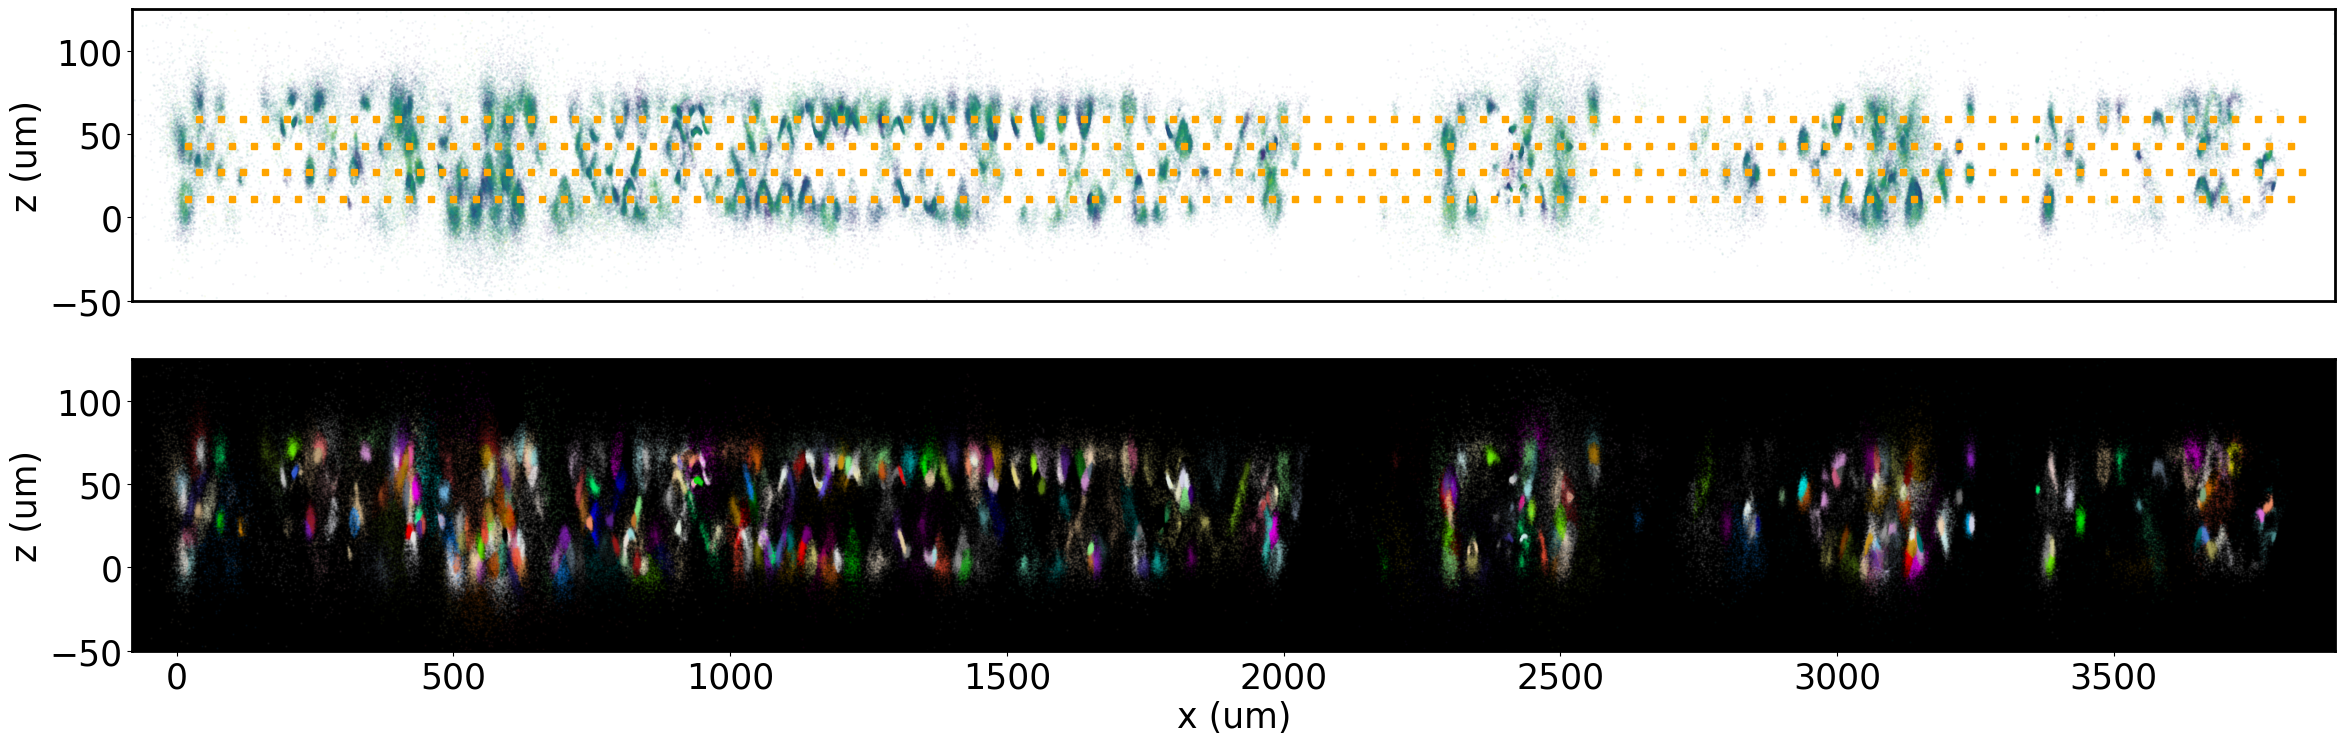

In [ ]:
fig = plt.figure(figsize=(24,8))

gs = GridSpec(2, 1) 
colors = [k for k,v in pltc.cnames.items()]
random.shuffle(colors)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:]) 

n_spikes = 1_000
channels = np.arange(384)
for idx in np.unique(spike_labels):
    c = int(idx)
    if idx >= len(colors):
        c = c // 6
        
    sub_data = spike_features[spike_labels == idx]
    x, z, maxptp = sub_data.T
    
    ax1.scatter(z[:n_spikes], x[:n_spikes], s=.5, alpha=0.05, c=maxptp[:n_spikes])
    ax2.scatter(z[:n_spikes], x[:n_spikes], s=.5, alpha=0.05, c=colors[c])
    
if len(channels) > 0: 
    for channel in channels:
        ax1.plot(np1_channel_map[int(channel), 1], np1_channel_map[int(channel), 0], 
                     markersize=5., c='orange', marker="s")
        # ax3.plot(np1_channel_map[int(channel), 0], np1_channel_map[int(channel), 1], 
        #              markersize=2.25, c='orange', marker="s")


ax1.set_ylim(-50, 125)
ax1.set_xlim(-80, 3900)
ax1.set_xticks([])
ax1.set_facecolor('white')
# plt.colorbar(ax=ax1, location='left')
ax2.set_ylim(-50, 125)
ax2.set_xlim(-80, 3900)
ax2.set_facecolor('black')
ax2.set_xlabel('x (um)')
ax1.set_ylabel('z (um)')
ax2.set_ylabel('z (um)')

plt.tight_layout()
# plt.savefig('cosyne_fig_1_panel_a.png', dpi=1000)

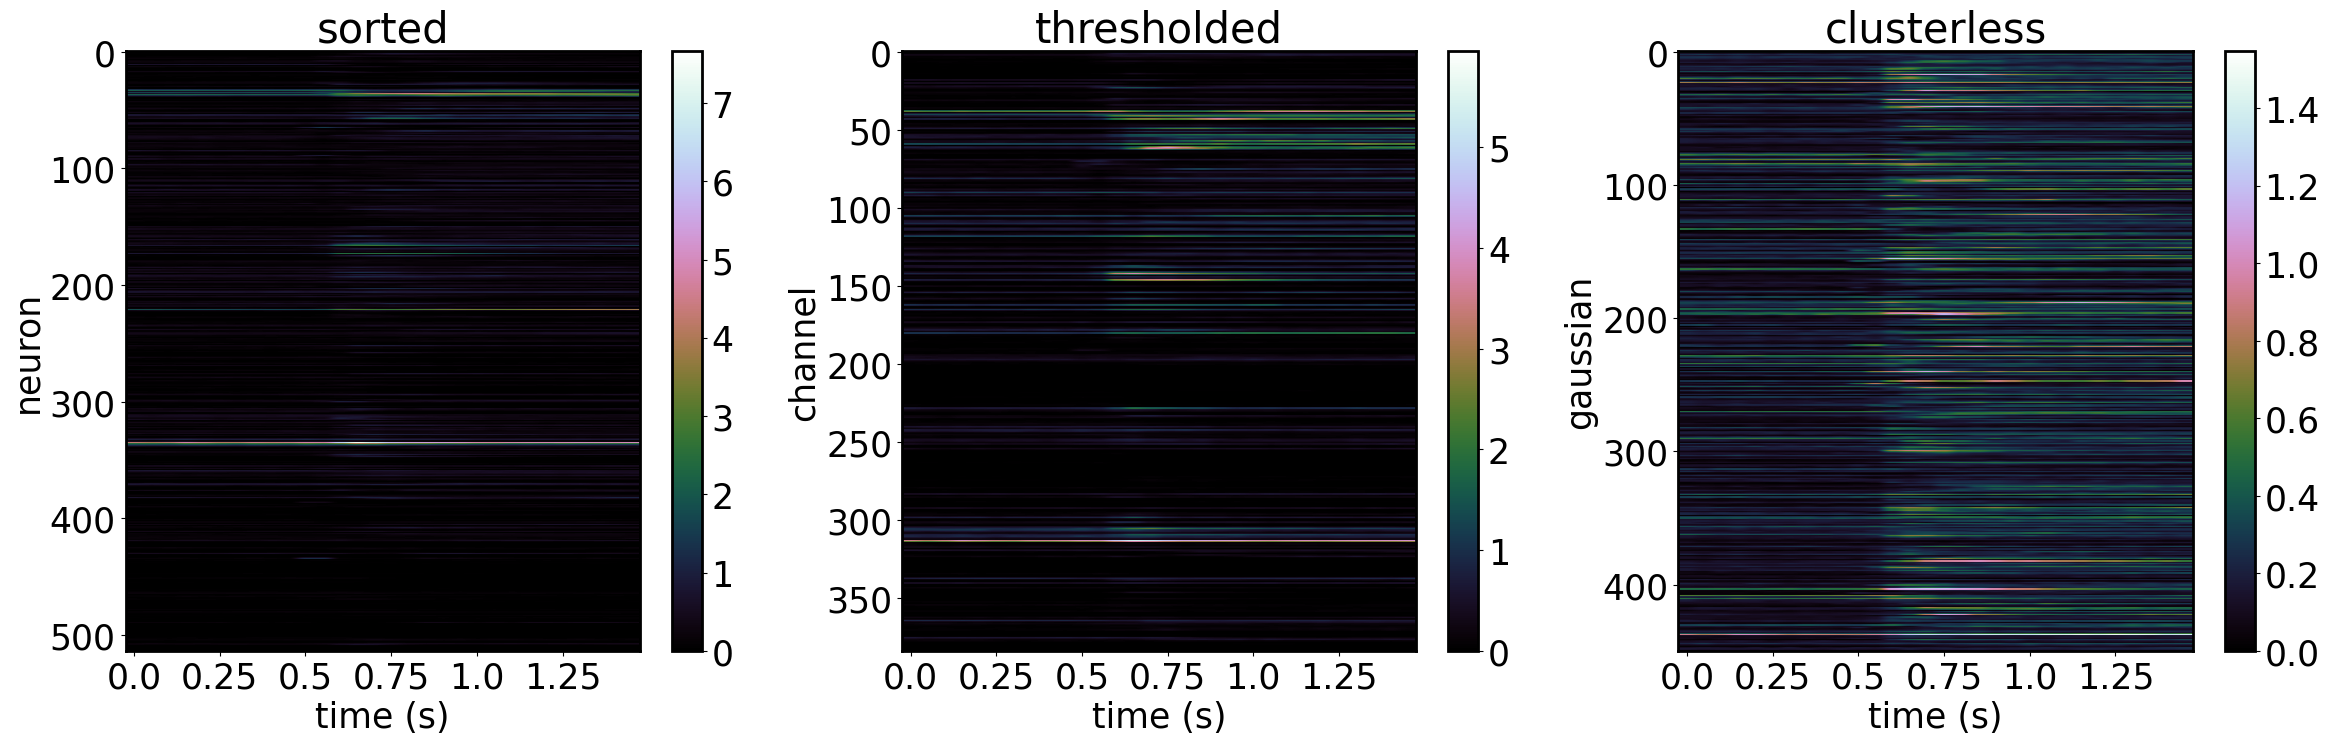

In [38]:
fig = plt.figure(figsize=(24,8))

gs = GridSpec(1, 3) 
colors = [k for k,v in pltc.cnames.items()]
random.shuffle(colors)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1]) 
ax3 = fig.add_subplot(gs[:,2]) 


p1 = ax1.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax1.set_title('sorted')
ax1.set_xlabel('time (s)') # change to seconds
ax1.set_ylabel('neuron')
ax1.set_xticks(np.arange(0, 30, 5), np.arange(0, 1.5, 0.25))
plt.colorbar(p1, ax=ax1);  # make color bars all same colorscale

        
p2 = ax2.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax2.set_title('thresholded')
ax2.set_xlabel('time (s)') # change to seconds
ax2.set_ylabel('channel')
ax2.set_xticks(np.arange(0, 30, 5), np.arange(0, 1.5, 0.25))
plt.colorbar(p2, ax=ax2);  # make color bars all same colorscale

p3 = ax3.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax3.set_title('clusterless')
ax3.set_xlabel('time (s)') # change to seconds
ax3.set_ylabel('gaussian')
ax3.set_xticks(np.arange(0, 30, 5), np.arange(0, 1.5, 0.25))
plt.colorbar(p3, ax=ax3);  # make color bars all same colorscale

plt.tight_layout()
# plt.savefig('cosyne_fig_1_panel_b.png', dpi=600)

In [12]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, _, wheel_speed, _, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

In [13]:
windowed_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [14]:
windowed_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [15]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)

In [16]:
windowed_wheel_speed = wheel_speed[:,half_window_size:n_windows].reshape(-1,1)
windowed_motion_energy = motion_energy[:,half_window_size:n_windows].reshape(-1,1)

In [17]:
cv_r2s, cv_rmses, _, _, sorted_motion_energy = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_motion_energy,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.461 rmse: 4.274
wheel speed fold 2 test r2: 0.488 rmse: 4.003
wheel speed fold 3 test r2: 0.551 rmse: 3.674
wheel speed fold 4 test r2: 0.540 rmse: 3.931
wheel speed fold 5 test r2: 0.522 rmse: 4.073
wheel speed mean of 5-fold cv r2: 0.512 rmse: 3.991
wheel speed sd of 5-fold cv r2: 0.033 rmse: 0.196


In [18]:
cv_r2s, cv_rmses, _, _, sorted_wheel_speed = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.469 rmse: 1.013
wheel speed fold 2 test r2: 0.499 rmse: 0.821
wheel speed fold 3 test r2: 0.488 rmse: 0.721
wheel speed fold 4 test r2: 0.422 rmse: 0.745
wheel speed fold 5 test r2: 0.488 rmse: 0.809
wheel speed mean of 5-fold cv r2: 0.473 rmse: 0.822
wheel speed sd of 5-fold cv r2: 0.027 rmse: 0.103


In [19]:
cv_r2s, cv_rmses, _, obs_wheel_speed, thresholded_motion_energy = decoder.cv_decode_dynamic(
    windowed_thresholded_neural_data,
    windowed_wheel_speed,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.461 rmse: 1.026
motion energy fold 2 test r2: 0.480 rmse: 0.852
motion energy fold 3 test r2: 0.482 rmse: 0.728
motion energy fold 4 test r2: 0.364 rmse: 0.820
motion energy fold 5 test r2: 0.485 rmse: 0.814
motion energy mean of 5-fold cv r2: 0.455 rmse: 0.848
motion energy sd of 5-fold cv r2: 0.046 rmse: 0.098


In [20]:
cv_r2s, cv_rmses, _, obs_wheel_speed, thresholded_wheel_speed = decoder.cv_decode_dynamic(
    windowed_thresholded_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.461 rmse: 1.026
wheel speed fold 2 test r2: 0.480 rmse: 0.852
wheel speed fold 3 test r2: 0.482 rmse: 0.728
wheel speed fold 4 test r2: 0.364 rmse: 0.820
wheel speed fold 5 test r2: 0.485 rmse: 0.814
wheel speed mean of 5-fold cv r2: 0.455 rmse: 0.848
wheel speed sd of 5-fold cv r2: 0.046 rmse: 0.098


In [21]:
cv_r2s, cv_rmses, _, obs_motion_energy, clusterless_motion_energy = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.468 rmse: 4.224
motion energy fold 2 test r2: 0.494 rmse: 3.953
motion energy fold 3 test r2: 0.537 rmse: 3.794
motion energy fold 4 test r2: 0.533 rmse: 3.995
motion energy fold 5 test r2: 0.509 rmse: 4.175
motion energy mean of 5-fold cv r2: 0.508 rmse: 4.028
motion energy sd of 5-fold cv r2: 0.025 rmse: 0.156


In [22]:
cv_r2s, cv_rmses, _, obs_wheel_speed, clusterless_wheel_speed = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.469 rmse: 1.013
wheel speed fold 2 test r2: 0.498 rmse: 0.822
wheel speed fold 3 test r2: 0.509 rmse: 0.690
wheel speed fold 4 test r2: 0.406 rmse: 0.765
wheel speed fold 5 test r2: 0.497 rmse: 0.795
wheel speed mean of 5-fold cv r2: 0.476 rmse: 0.817
wheel speed sd of 5-fold cv r2: 0.037 rmse: 0.107


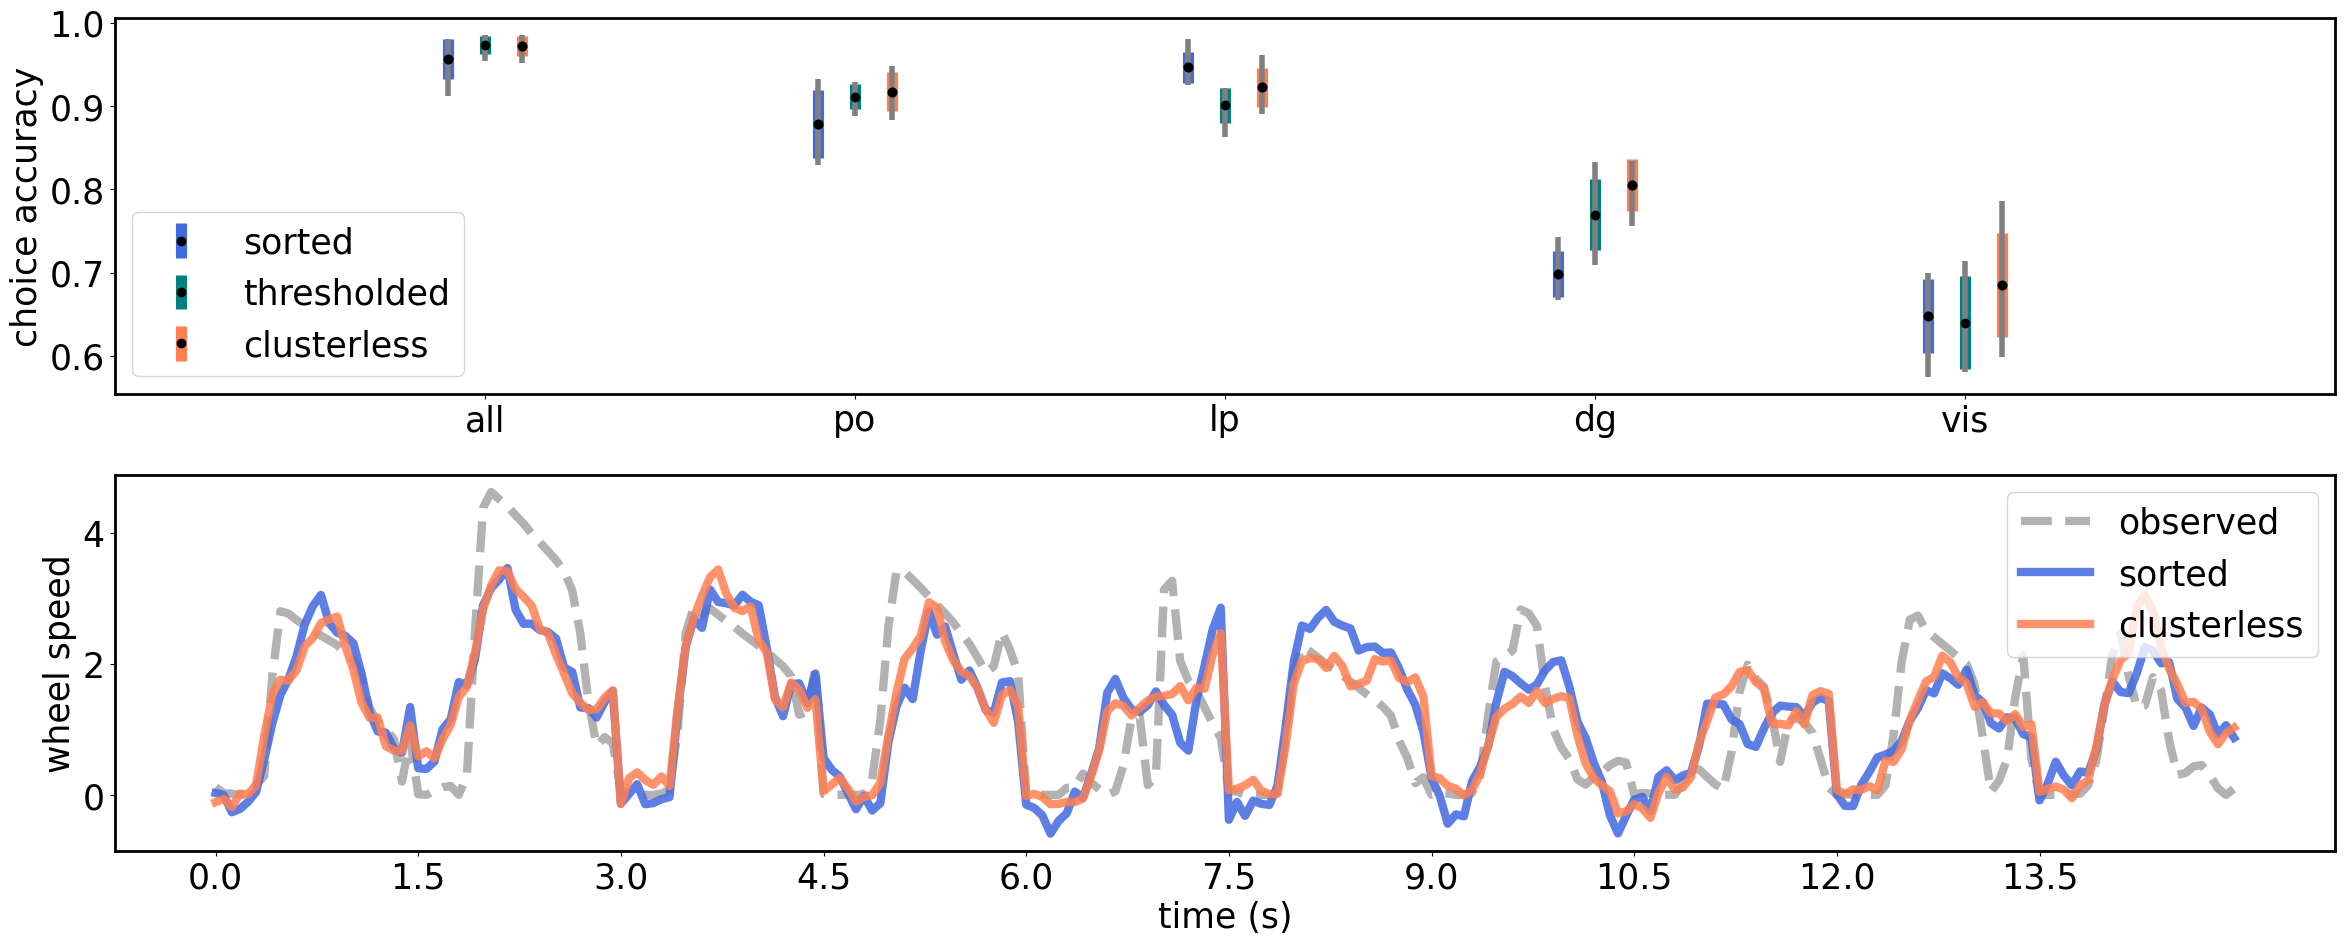

In [53]:
fig = plt.figure(figsize=(24,10))

gs = GridSpec(2, 1) 

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1]) 
# ax3 = fig.add_subplot(gs[2]) 

rois = ['po', 'lp', 'dg', 'ca1', 'vis']

all_decode_results = np.load(
        f'{save_path}/static_behaviors/all_decode_results.npy', allow_pickle=True).item()
    
regional_decode_results = {
    rois[0]: np.load(
        f'{save_path}/static_behaviors/{rois[0]}_decode_results.npy', allow_pickle=True).item(),
    rois[1]: np.load(
        f'{save_path}/static_behaviors/{rois[1]}_decode_results.npy', allow_pickle=True).item(),     
    rois[2]: np.load(
        f'{save_path}/static_behaviors/{rois[2]}_decode_results.npy', allow_pickle=True).item(),
    rois[3]: np.load(
        f'{save_path}/static_behaviors/{rois[3]}_decode_results.npy', allow_pickle=True).item(),
    rois[4]: np.load(
        f'{save_path}/static_behaviors/{rois[4]}_decode_results.npy', allow_pickle=True).item()
}

idx = 1
behave_type = 'choice'
data_type = 'sorted'
sorted = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'thresholded'
thresholded = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'clusterless'
clusterless = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])

# ticks = rois.copy(); ticks.insert(0, 'all')
ticks = ['po', 'lp', 'dg', 'vis']; ticks.insert(0, 'all')

mins, maxs, means, stds = sorted.min(1), sorted.max(1), sorted.mean(1), sorted.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8, label='sorted')
ax1.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = thresholded.min(1), thresholded.max(1), thresholded.mean(1), thresholded.std(1)
ax1.errorbar(np.arange(len(ticks))*2, means, stds, 
             fmt='ok', ecolor='teal', lw=8, label='thresholded')
ax1.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = clusterless.min(1), clusterless.max(1), clusterless.mean(1), clusterless.std(1)
ax1.errorbar(np.arange(len(ticks))*2+.2, means, stds, 
             fmt='ok', ecolor='coral', lw=8, label='clusterless')
ax1.errorbar(np.arange(len(ticks))*2+.2, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

ax1.legend(loc='lower left')
ax1.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax1.set_xlim(-2, len(ticks)*2)
ax1.set_ylabel('choice accuracy')

# ax2.plot(np.hstack([obs_motion_energy[0][i] for i in range(0, 50, 5)]), 
#          c='gray', linestyle='dashed', label='observed');
# ax2.plot(np.hstack([sorted_motion_energy[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), 
#          c='royalblue', alpha=.8, linewidth=3., label='sorted');
# # ax2.plot(np.hstack([thresholded_motion_energy[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), 
#          # c='royalblue', alpha=1., linewidth=3., label='thresholded');
# ax2.plot(np.hstack([clusterless_motion_energy[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), 
#          c='coral', alpha=.8, linewidth=3., label='clusterless');
# ax2.set_xlabel('time');
# ax2.set_ylabel('motion energy');
# ax2.legend();


ax2.plot(np.hstack([obs_wheel_speed[2][i] for i in range(0, 50, 5)]), alpha=.6, linewidth=6.,
         c='gray', linestyle='dashed', label='observed');
ax2.plot(np.hstack([sorted_wheel_speed[2].reshape(-1, 25)[i] for i in range(0, 50, 5)]), 
         c='royalblue', alpha=.85, linewidth=6., label='sorted');
ax2.plot(np.hstack([clusterless_wheel_speed[2].reshape(-1, 25)[i] for i in range(0, 50, 5)]), 
         c='coral', alpha=.85, linewidth=6., label='clusterless');
ax2.set_xlabel('time (s)');
ax2.set_ylabel('wheel speed');
ax2.set_xticks(np.arange(0, 250, 25), np.arange(0, 15, 1.5))
ax2.legend();

plt.tight_layout()
# plt.savefig('cosyne_fig_2.png', dpi=600)